In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from torch import nn
from transformers import DistilBertModel

# Definisce una classe per un classificatore BERT
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()

        # Carica il modello BERT preaddestrato e congela i parametri
        self.bert = DistilBertModel.from_pretrained(bert_model_name)

        # Aggiunge uno strato di dropout per prevenire l'overfitting
        self.dropout = nn.Dropout(0.1)

        # Aggiunge uno strato completamente connesso per la classificazione
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    # Definisce il metodo forward, che specifica come l'input deve essere trasformato in output
    def forward(self, input_ids, attention_mask):
        # Run the DistilBERT model on the input
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)

        # Extract the [CLS] token's embedding (first token in the last hidden state)
        cls_output = outputs.last_hidden_state[:, 0, :]

        # Apply dropout to the [CLS] token representation
        x = self.dropout(cls_output)

        # Pass through the fully connected layer to get classification logits
        logits = self.fc(x)

        # Return the logits
        return logits

In [ ]:
import pandas as pd

# Funzione per caricare i dati da un file Excel
def load_data(data_file):
    # Legge il file Excel utilizzando pandas e lo memorizza in un DataFrame
    df = pd.read_excel(data_file)

    # Estrae le colonne 'Review' e 'Promotore' dal DataFrame
    texts = df['Review'].tolist()
    labels = df['Promotore'].tolist()

    # Restituisce i testi e le etichette come liste
    return texts, labels

In [ ]:
import torch
from torch import nn
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Funzione di addestramento del modello con monitoraggio della perdita e barra di avanzamento
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0

    # Creazione della barra di avanzamento per il training
    progress_bar = tqdm(data_loader, desc="Training", leave=False)

    for batch in progress_bar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        # Calcolo dell'output e della perdita
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)

        total_loss += loss.item()

        # Backpropagation e aggiornamento pesi
        loss.backward()
        optimizer.step()
        scheduler.step()

        # Aggiorna la descrizione della barra di avanzamento per mostrare la perdita media
        progress_bar.set_postfix({"Loss": loss.item()})

    # Restituisce la perdita media per batch
    return total_loss / len(data_loader)

def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    probabilities = []
    total_loss = 0

    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            # Ottieni i logits del modello
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            probs = torch.softmax(outputs, dim=1)[:, 1] # Probabilità per la classe positiva

            # Aggiungi predizioni e etichette alla lista
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
            probabilities.extend(probs.cpu().tolist())

    # Calcola accuracy
    accuracy = accuracy_score(actual_labels, predictions)
    print(f"Accuracy: {accuracy:.4f}")

    # Calcola e stampa il Classification Report
    report = classification_report(actual_labels, predictions, target_names=["Negative", "Positive"])
    print("\nClassification Report:\n", report)

    # Calcola ROC e AUC
    fpr, tpr, _ = roc_curve(actual_labels, probabilities)
    roc_auc = auc(fpr, tpr)
    print(f"AUC: {roc_auc:.4f}")

    # Grafico ROC
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.show()

    # Matrice di Confusione
    cm = confusion_matrix(actual_labels, predictions)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Predicted Negative", "Predicted Positive"],
                yticklabels=["Actual Negative", "Actual Positive"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, report, roc_auc

In [ ]:
import torch
from torch.utils.data import Dataset

# Definisce una classe per il dataset di classificazione spam
class ClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer):
        # Inizializza il dataset con testi, etichette e un tokenizer
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer

    def __len__(self):
        # Restituisce la lunghezza del dataset (numero di campioni)
        return len(self.texts)

    def __getitem__(self, idx):
        # Ottiene un campione dal dataset dato un indice
        text = self.texts[idx]
        label = self.labels[idx]

        # Tokenizza il testo e restituisce i tensori PyTorch risultanti
        encoding = tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128)

        # Restituisce un dizionario con input_ids, attention_mask e label
        return {
          'input_ids': encoding['input_ids'].squeeze(0),
          'attention_mask': encoding['attention_mask'].squeeze(0),
          'label': torch.tensor(label, dtype=torch.long)
        }

In [ ]:
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
# from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup, DistilBertTokenizer
from torch.optim import AdamW

# Definizione dei file dei dati e caricamento dei dati
data_file = "data_classification_80.xlsx"
texts, labels = load_data(data_file)

In [ ]:
# Settaggio dei parametri
# bert_model_name = 'bert-base-uncased'
bert_model_name = 'distilbert-base-uncased'
num_classes = 2
batch_size = 128
learning_rate = 1e-5

In [ ]:
# Divisione dei dati in set di addestramento e validazione
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, stratify=labels)

In [ ]:
reduced_train, reduced_train_labels = train_texts[:1000], train_labels[:1000]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]


Epoch 1/5


Training Loss: 0.6585
Accuracy: 0.8402

Classification Report:
               precision    recall  f1-score   support

    Negative       0.85      0.82      0.84     34354
    Positive       0.83      0.86      0.84     34581

    accuracy                           0.84     68935
   macro avg       0.84      0.84      0.84     68935
weighted avg       0.84      0.84      0.84     68935

AUC: 0.9241


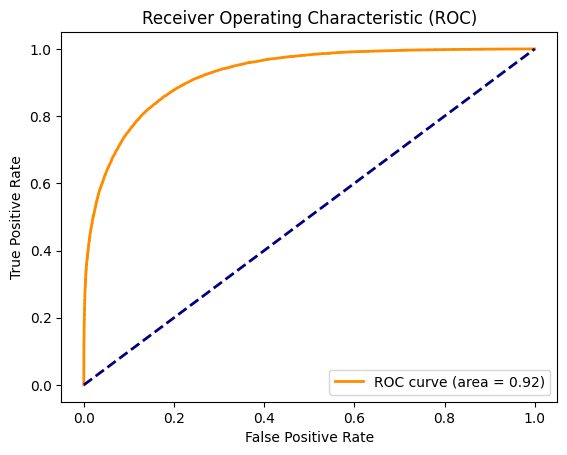

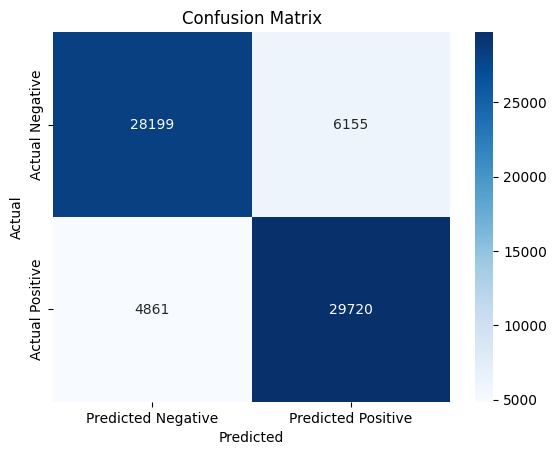

Model saved with improved validation loss!
Early stopping triggered. Stopping training.


In [ ]:
# Creazione del tokenizzatore BERT e dei dataset PyTorch
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
train_dataset = ClassificationDataset(reduced_train, reduced_train_labels, tokenizer)
val_dataset = ClassificationDataset(val_texts, val_labels, tokenizer)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Verifica la disponibilità della GPU e sposta il modello sul dispositivo appropriato
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

# Definizione dell'ottimizzatore
num_epochs = 5
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

patience = 0  # Numero di epoche senza miglioramento per fermare l'addestramento
best_val_loss = float("inf")
counter = 0

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Addestramento con barra di avanzamento
    avg_loss = train(model, train_dataloader, optimizer, scheduler, device)
    print(f"Training Loss: {avg_loss:.4f}")

    # Valutazione con barra di avanzamento
    accuracy, report, roc_auc = evaluate(model, val_dataloader, device)

    val_loss = 1 - accuracy

    # Early stopping e salvataggio del miglior modello
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "demo_distilbert_classifier.pth")
        print("Model saved with improved validation loss!")
        counter = 0
    else:
        counter += 1
        print(f"No improvement in validation loss. Early stopping counter: {counter}/{patience}")

    if counter >= patience:
        print("Early stopping triggered. Stopping training.")
        break

In [ ]:
# Train of the final model on the overall dataset
# Creazione del tokenizzatore BERT e dei dataset PyTorch
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)
dataset = ClassificationDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Verifica la disponibilità della GPU e sposta il modello sul dispositivo appropriato
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

num_epochs = 1

# Definizione dell'ottimizzatore
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Addestramento con barra di avanzamento
    avg_loss = train(model, dataloader, optimizer, scheduler, device)
    print(f"Training Loss: {avg_loss:.4f}")

    torch.save(model.state_dict(), "distilbert_classifier.pth")


Epoch 1/1


Training Loss: 0.0625


In [ ]:
# Carica il modello BERT
bert_model_name = 'distilbert-base-uncased'  # Usa lo stesso modello utilizzato per l'addestramento
num_classes = 2  # Numero di classi (positiva e negativa)

# Inizializza il modello
loaded_model = BERTClassifier(bert_model_name, num_classes)

# Carica i pesi del modello salvato
loaded_model.load_state_dict(torch.load("distilbert_classifier.pth"))

# Sposta il modello su GPU o CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loaded_model.to(device)

# Imposta il modello in modalità di valutazione
loaded_model.eval()

print("Model loaded successfully!")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

<ipython-input-6-3a310d6c915e>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load("distilbert_classifier.pth"))


Model loaded successfully!


In [ ]:
# Carica il tokenizer
tokenizer = DistilBertTokenizer.from_pretrained(bert_model_name)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
# Definizione dei file dei dati e caricamento dei dati
test_file = "data_classification_20.xlsx"
test_texts, test_labels = load_data(test_file)

test_dataset = ClassificationDataset(test_texts, test_labels, tokenizer)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
from tqdm import tqdm

def predict_on_test_set(test_dataloader, model, device):
    # Set the model to evaluation mode
    model.eval()

    # List to store predictions
    predictions = []

    # Disable gradient calculation for inference
    with torch.no_grad():
        # Iterate over the batches in the DataLoader with a progress bar
        for batch in tqdm(test_dataloader, desc="Processing test data"):
            # Get the input data from the batch
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            # Run the model to get predictions
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)

            # Get the predicted class labels (0 or 1)
            _, preds = torch.max(outputs, dim=1)

            # Add the predictions to the list
            predictions.extend(preds.cpu().tolist())

    # Return the list of predictions
    return predictions

In [ ]:
# Get predictions on the test set using the DataLoader
predictions = predict_on_test_set(test_dataloader, loaded_model, device)

Processing test data: 100%|██████████| 674/674 [06:39<00:00,  1.69it/s]


In [ ]:
accuracy = accuracy_score(test_labels, predictions)

In [ ]:
print(accuracy)
# Print the predictions (each prediction will be either 0 or 1)
print(predictions)

0.9836598273140841
[1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,